# Spacecharge Benchmark - Comparing to Bmad



In [1]:
import matplotlib.pyplot as plt
import numpy as np
from pmd_beamphysics import ParticleGroup
from pytao import Tao
from scipy.constants import c

import impact.z as IZ
from impact.tests.z.conftest import bmad_files
from impact.z.interfaces.bmad import plot_impactz_and_tao_stats

In [2]:
TRACK_START = "BEGINNING"
TRACK_END = "END"

BUNCH_CHARGE = 1e-9

NX = 32
NY = 32
NZ = 32
N_PARTICLE = 10_000
DS_STEP = 0.01

BMAD_SC_ON = True

CHIRP = 0

LATTICE_FILE = bmad_files / "drift.bmad"

E_TOT = 10e6
BETA_A = 1000
BETA_B = 1000

## Tao

In [3]:
# Gaussian
def set_gaussian(
    tao,
    n_particle=N_PARTICLE,
    a_emit=1.0e-9,
    b_emit=1.0e-9,
    bunch_charge=1e-9 / 1000,
    sig_pz0=1e-4,
    sig_z=1e-4,
    center_pz=0,
    chirp=0,  # 1/m
    random_engine="quasi",
    random_sigma_cutoff=4,
):
    sig_pz = np.hypot(sig_pz0, chirp * sig_z)

    cmds = [
        f"set beam_init n_particle = {n_particle}",
        f"set beam_init random_engine = {random_engine}",
        f"set beam_init a_emit = {a_emit}",
        f"set beam_init b_emit = {b_emit}",
        f"set beam_init bunch_charge = {bunch_charge}",
        f"set beam_init sig_pz = {sig_pz}",
        f"set beam_init sig_z = {sig_z}",
        f"set beam_init dpz_dz = {chirp}",
        f"set beam_init center(6) = {center_pz}",
        f"set beam_init random_sigma_cutoff = {random_sigma_cutoff}",
    ]
    tao.cmds(cmds)
    tao.cmd("set global lattice_calc_on = T")


def get_particles(tao, ele_id):
    return ParticleGroup(data=tao.bunch_data(ele_id))

In [4]:
tao = Tao(lattice_file=LATTICE_FILE, plot="mpl")

tao.cmd(f"set ele beginning e_tot = {E_TOT}")
tao.cmd(f"set ele beginning beta_a = {BETA_A}")
tao.cmd(f"set ele beginning beta_b = {BETA_B}")

set_gaussian(tao, n_particle=N_PARTICLE, bunch_charge=BUNCH_CHARGE, chirp=CHIRP)

In [5]:
tao.cmd("set bmad_com csr_and_space_charge_on = T")
tao.cmd("set space_charge particle_bin_span = 1")
tao.cmd(f"set space_charge n_bin = {NZ}")
tao.cmd(f"set space_charge ds_track_step = {DS_STEP}")
tao.cmd("set bmad_com radiation_damping_on  = T")  # off by default
tao.cmd("set bmad_com radiation_fluctuations_on = T")  # off by default

if BMAD_SC_ON:
    tao.cmd("set ele * space_charge_method = fft_3d")
    tao.cmd(f"set space_charge space_charge_mesh_size = {NX} {NY} {NZ}")
else:
    tao.cmd("set ele * space_charge_method = off")
tao.cmd(f"set ele * DS_STEP = {DS_STEP}")

[]

CPU times: user 11.7 s, sys: 10.2 ms, total: 11.7 s
Wall time: 3.11 s


(None, np.float64(147.45204794535664))

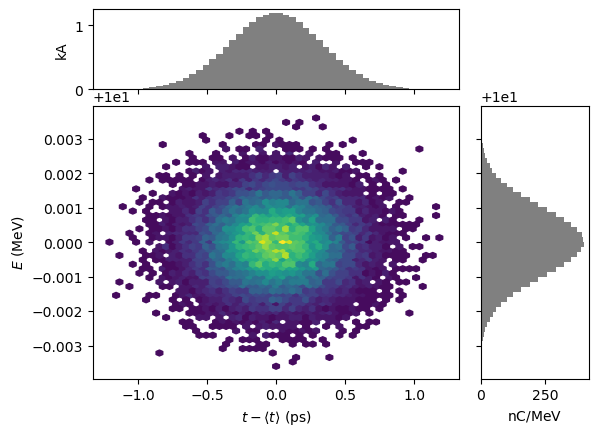

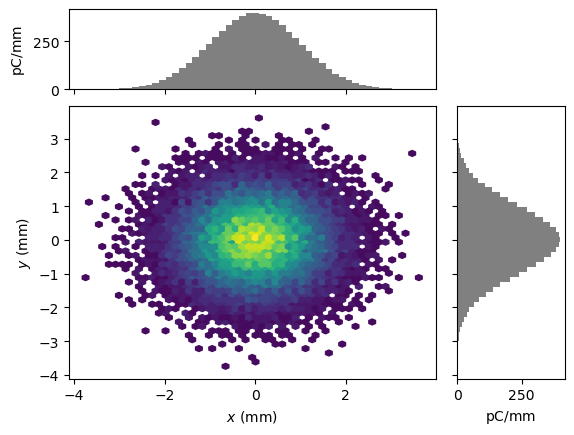

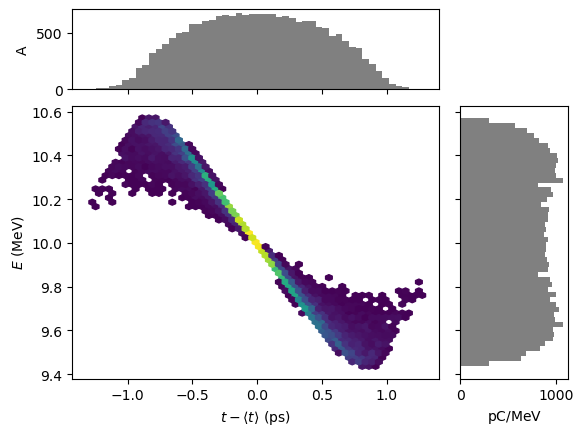

In [6]:
%%time
tao.cmd("set global track_type = beam; set global track_type = single")

P0 = get_particles(tao, "beginning")
P1 = get_particles(tao, "end")

P0.plot("delta_t", "energy")
P0.plot("x", "y")
P1.plot("delta_t", "energy"), P1["sigma_t"] * c * 1e6

## Impact-Z

In [7]:
input = IZ.ImpactZInput.from_tao(tao, verbose=False, write_beam_eles="")
I = IZ.ImpactZ(input)  # , use_temp_dir=False, workdir="./tmp-sc-bench")
I.initial_particles = P0

In [8]:
if tao.bmad_com()["csr_and_space_charge_on"]:
    I.input.space_charge_on()

# I.input.integrator_type = 1

In [9]:
I.input

ImpactZInput(
    initial_particles=<ParticleGroup with 10000 particles at 0x7f9db5982660>,
    ncpu_y=1,
    ncpu_z=1,
    gpu=IZ.GPUFlag.disabled,
    seed=-1,
    n_particle=10000,
    integrator_type=IZ.IntegratorType.linear_map,
    err=1,
    diagnostic_type=IZ.DiagnosticType.extended,
    nx=32,
    ny=32,
    nz=32,
    boundary_type=IZ.BoundaryType.trans_open_longi_open,
    radius_x=0.0,
    radius_y=0.0,
    z_period_size=0.0,
    distribution=IZ.DistributionType.read,
    restart=0,
    subcycle=0,
    nbunch=1,
    particle_list=[10000],
    current_list=[1.2999999999999998],
    charge_over_mass_list=[-1.956951180916719e-06],
    twiss_alpha_x=0.0,
    twiss_beta_x=1000.0,
    twiss_norm_emit_x=1e-06,
    twiss_mismatch_x=1.0,
    twiss_mismatch_px=1.0,
    twiss_offset_x=0.0,
    twiss_offset_px=0.0,
    twiss_alpha_y=0.0,
    twiss_beta_y=1000.0,
    twiss_norm_emit_y=1e-06,
    twiss_mismatch_y=1.0,
    twiss_mismatch_py=1.0,
    twiss_offset_y=0.0,
    twiss_offset_py=0.0,
    twiss_alpha_z=1e-09,
    twiss_beta_z=1.0,
    twiss_norm_emit_z=1e-06,
    twiss_mismatch_z=1.0,
    twiss_mismatch_e_z=1.0,
    twiss_offset_phase_z=0.0,
    twiss_offset_energy_z=0.0,
    average_current=1.2999999999999998,
    reference_kinetic_energy=9489001.04931,
    reference_particle_mass=510998.95069,
    reference_particle_charge=-1.0,
    reference_frequency=1300000000.0,
    initial_phase_ref=0.0,
    lattice=[
        WriteFull(
            name='initial_particles',
            metadata={},
            length=0.0,
            steps=0,
            file_id=100,
            type_id=-2,
            unused_2=0.0,
            sample_frequency=0
        ),
        ToggleSpaceCharge(
            name='',
            metadata={},
            length=0.0,
            steps=0,
            map_steps=0,
            type_id=-14,
            unused=0.0,
            enable=True
        ),
        Drift(
            name='D',
            metadata={'bmad_csr': False, 'bmad_sc': True, 'bmad_id': 1},
            length=1.0,
            steps=100,
            map_steps=100,
            type_id=0,
            radius=1.0
        ),
        WriteFull(
            name='final_particles',
            metadata={},
            length=0.0,
            steps=0,
            file_id=101,
            type_id=-2,
            unused_2=0.0,
            sample_frequency=0
        )
    ],
    filename=None,
    verbose=False
)

In [10]:
%%time
I.nproc = 1
I.run(verbose=False);

<!-- lume-impact detected Jupyter and will use HTML for rendering. -->

  0%|          | 0/4 [00:00<?, ?it/s]

CPU times: user 304 ms, sys: 18 ms, total: 322 ms
Wall time: 2.89 s


np.float64(1.4663186329165132)

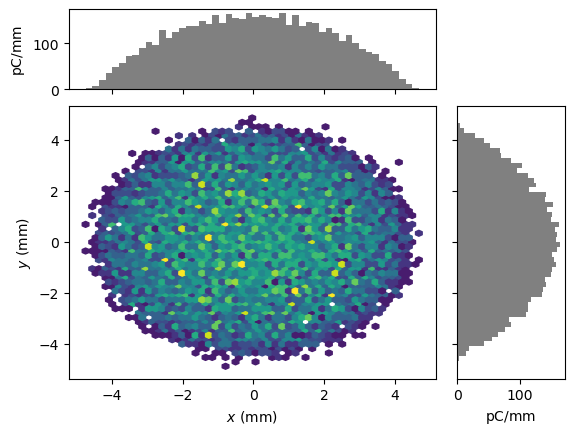

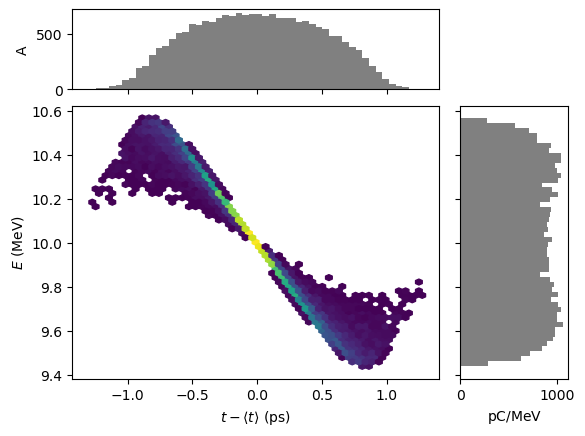

In [11]:
P20 = I.output.particles["initial_particles"]
P2 = I.output.particles["final_particles"]
P2.plot("x", "y")
P2.plot("delta_t", "energy")
P2["sigma_t"] / P20["sigma_t"]

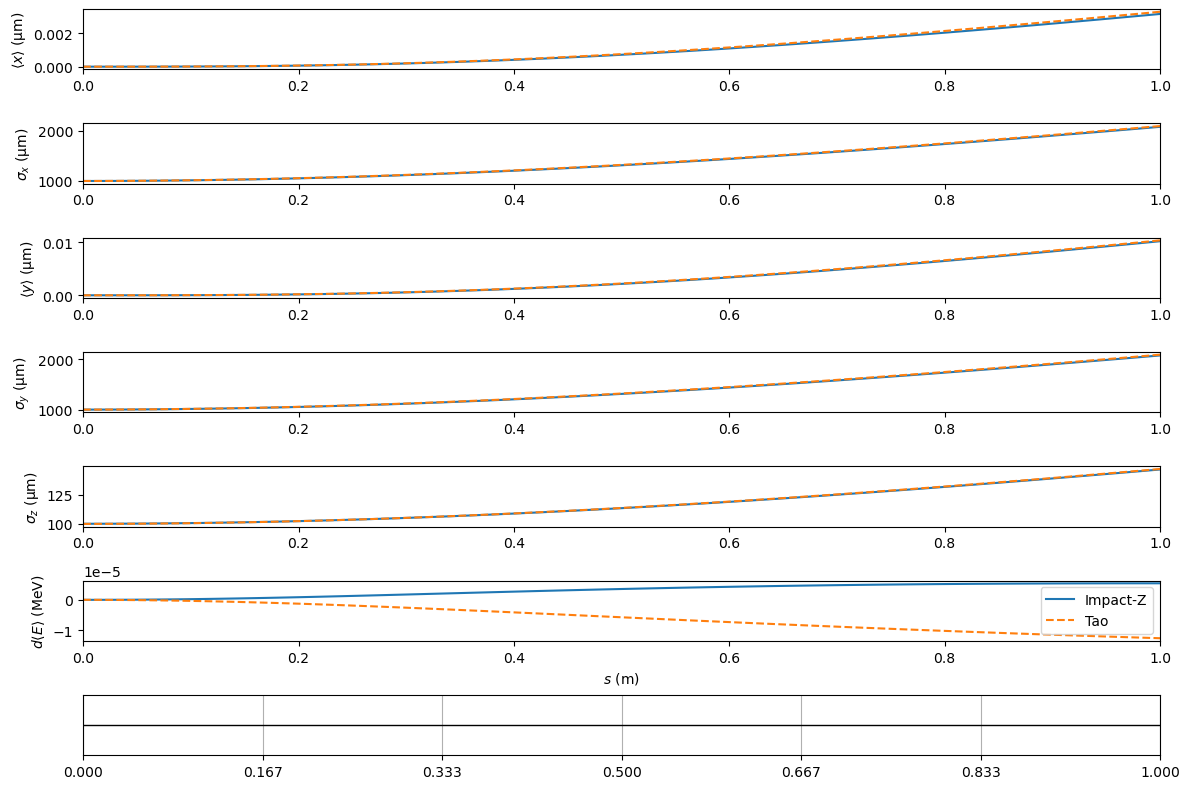

In [12]:
plot_impactz_and_tao_stats(I, tao)

# Compare

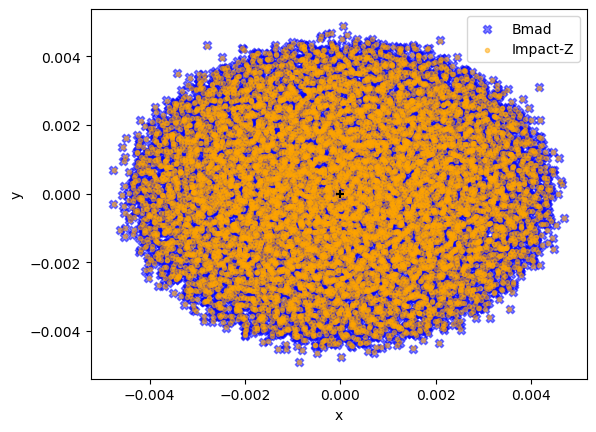

In [13]:
def compare(
    xkey="x",
    ykey="y",
):
    fig, ax = plt.subplots()

    plist = (
        (P1, "Bmad", "X", "blue"),
        (P2, "Impact-Z", ".", "orange"),
    )

    for p, label, marker, color in plist:
        ax.scatter(p[xkey], p[ykey], label=label, marker=marker, alpha=0.5, color=color)

    for p, label, marker, color in plist:
        ax.scatter(
            p["mean_" + xkey],
            p["mean_" + ykey],
            marker="+",
            color=color,
            facecolor="black",
        )

    plt.legend()

    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)


compare()

In [14]:
P1["mean_x"], P2["mean_x"]

(np.float64(3.274573557836163e-09), np.float64(3.1428927887721586e-09))

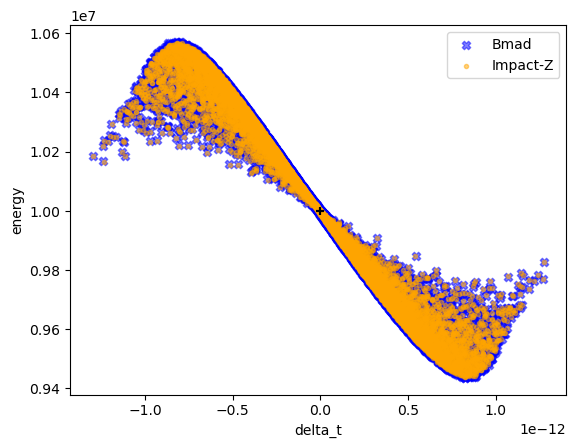

In [15]:
compare("delta_t", "energy")

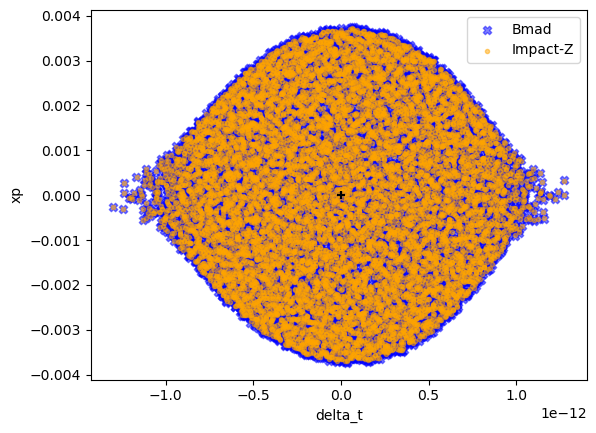

In [16]:
compare("delta_t", "xp")

In [17]:
energy0 = P0["mean_energy"]
P1["mean_energy"] - energy0, P2["mean_energy"] - energy0

(np.float64(0.15698212757706642), np.float64(5.431377984583378))

# Impact-Z Lorentz integrator 

`ImpactZInput.integrator_type = 2`

Note that this is not expected to work as well because the dipole fringe fields are not able to be specified.

In [18]:
I2 = I.copy()

In [19]:
I2.input.integrator_type = 2
I2.run(verbose=False)

P3 = I2.output.particles["final_particles"]

  0%|          | 0/4 [00:00<?, ?it/s]

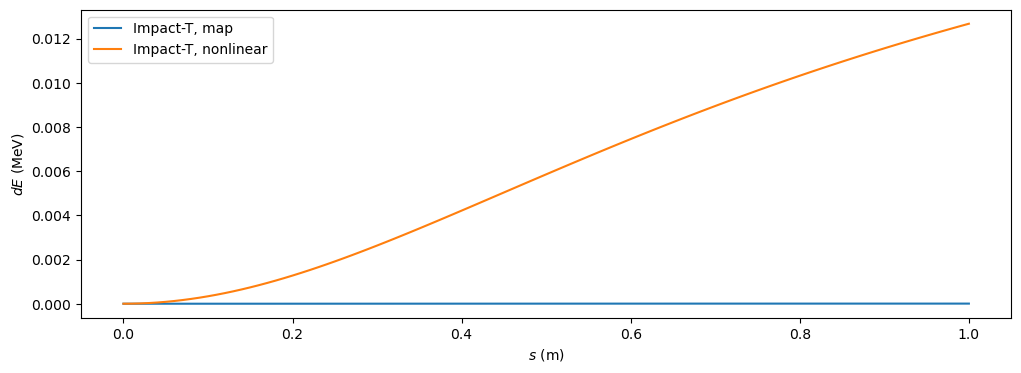

In [20]:
stats1 = I.output.stats
stats2 = I2.output.stats

eref = I.output.stats.energy_ref[0]  # should be constant

fig, ax = plt.subplots(1, figsize=(12, 4))

ax.plot(stats1.z, (stats1.mean_energy - eref) / 1e6, label="Impact-T, map")
ax.plot(stats2.z, (stats2.mean_energy - eref) / 1e6, label="Impact-T, nonlinear")

ax.set_xlabel(r"$s$ (m)")
ax.set_ylabel(r"$dE$ (MeV)")

plt.legend()

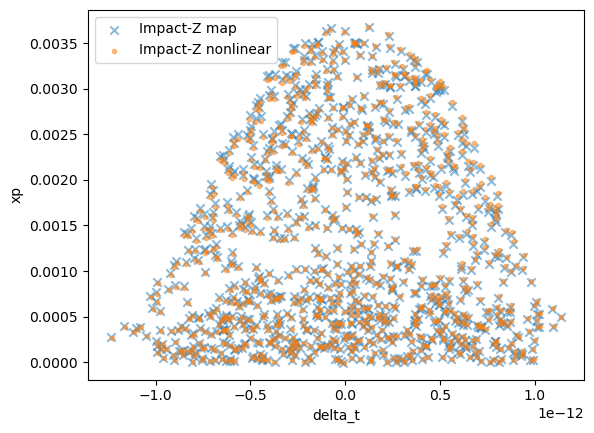

In [21]:
def compare(
    xkey="x",
    ykey="y",
    skip=10,
):
    fig, ax = plt.subplots()

    for p, label, marker in (
        #   (P1, "Bmad", "X"),
        (P2, "Impact-Z map", "x"),
        (P3, "Impact-Z nonlinear", "."),
    ):
        ax.scatter(
            p[xkey][::skip], p[ykey][::skip], label=label, marker=marker, alpha=0.5
        )

    plt.legend()

    ax.set_xlabel(xkey)
    ax.set_ylabel(ykey)


compare("delta_t", "xp")

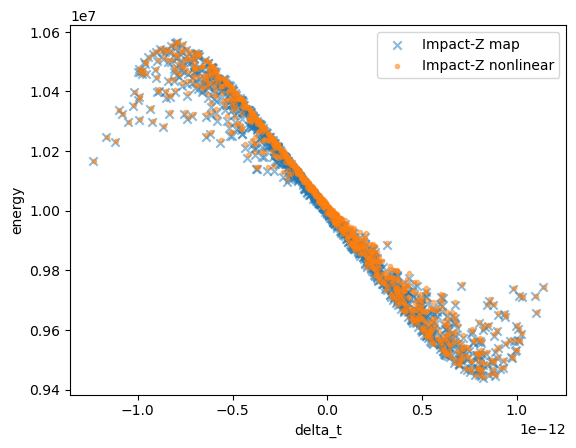

In [22]:
compare("delta_t", "energy")